In [1]:
########## Packages ##########
from casadi import *
import numpy as np
import os 
import matplotlib.pyplot as plt 
##############################

########### plt ##########
plt.rcParams["font.family"] = "serif"       # fonts
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 18              
plt.rcParams["mathtext.cal"] = "serif"      
plt.rcParams["mathtext.rm"] = "serif"       
plt.rcParams["mathtext.it"] = "serif:italic"
plt.rcParams["mathtext.bf"] = "serif:bold"  
plt.rcParams["mathtext.fontset"] = "cm"     
###########################

In [2]:
class Direct_single_shooting():
    """
    Solve optimal control problem numerically using direct single shooting method.
    """
    def __init__(self, T, N):
        self.T = T  # time horizon
        self.N = N  # number of control intervals
    
    def model_equation(self, x0, x1, u):
        """
        model equation
        dx_0/dt = (1 - x_1^2)x_0 - x_1 + u
        dx_1/dt = x_0
        """
        return vertcat((1 - x1**2)*x0 - x1 + u, x0)
    
    def stage_cost(self, x0, x1, u):
        """
        stage cost
        L(x, u) = x_0^2 + x_1^2 + u^2
        """
        return x0**2 + x1**2 + u**2 
    
    def discrete_dynamics(self, x0, x1, u):
        """
        Formulate discrete time dynamics
        """
        x = vertcat(x0, x1)
        xdot = self.model_equation(x0, x1, u)
        L = self.stage_cost(x0, x1, u)
        # CVODES from the SUNDIALS suite
        dae = {'x': x, 'p': u, 'ode': xdot, 'quad': L}
        opts = {'tf': self.T/self.N}
        F = integrator('F', 'cvodes', dae, opts)
        return F 
    
    def nlp(self, x0, x1, u, xinit):
        """
        Formulate and solve the NLP
        Given
        - x, u: MX.sym 
        - xinit: initial value of x
        """
        # discrete time dynamics
        F = self.discrete_dynamics(x0, x1, u)

        # empty
        w = []
        w0 = []
        lbw = []
        ubw = []
        J = 0 
        g = []
        lbg = []
        ubg = []

        # Formulate the NLP
        Xk = MX(xinit)
        for k in range(self.N):
            # New NLP variable for the control
            Uk = MX.sym('U_' + str(k))
            w += [Uk]
            lbw += [-1]         # lower bound of u
            ubw += [1]          # upper bound of u
            w0 += [0]

            # Integrate till the end of the interval
            Fk = F(x0=Xk, p=Uk)
            Xk = Fk['xf']
            J = J + Fk['qf']

            # Add inequality constraints
            g += [Xk[0]]
            lbg += [-0.25]         # lower bound of x 
            ubg += [inf]          # upper bound of x
        
        # Create an NLP slver
        prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
        solver = nlpsol('solver', 'ipopt', prob)

        # Solve the NLP 
        sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
        return sol 
    
    def plot_solution(self, x0, x1, u, xinit):
        """
        Plot the solution
        Given
        - x, u: MX.sym 
        - xinit: initial value of x
        """
        F = self.discrete_dynamics(x0, x1, u)
        sol = self.nlp(x0, x1, u, xinit)
        u_opt = sol['x']
        x_opt = [xinit]
        for k in range(self.N):
            Fk = F(x0=x_opt[-1], p=u_opt[k])
            x_opt.append(Fk['xf'].full())
        x0_opt = [r[0] for r in x_opt]
        x1_opt = [r[1] for r in x_opt]

        tgrid = [self.T/self.N*k for k in range(self.N + 1)]

        fig = plt.figure(figsize=(10, 7.5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(tgrid, x0_opt, '--', label=r'$x_0$')
        ax.plot(tgrid, x1_opt, '-', label=r'$x_1$')
        ax.step(tgrid, vertcat(DM.nan(1), u_opt), '-.', label=r'$u$')
        ax.legend(loc='best')
        ax.set_xlabel(r'$t$'); ax.set_ylabel(r'$x_0, x_1, u$')
        ax.set_xlim([0, self.T])
        ax.grid(True)
        plt.show()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      210
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equa

/usr/local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


  38  3.7329818e+00 0.00e+00 6.50e-07  -8.6 1.13e-05    -  1.00e+00 1.00e+00h  1
  39  3.7329818e+00 0.00e+00 3.55e-09  -8.6 1.37e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   3.7329818165222717e+00    3.7329818165222717e+00
Dual infeasibility......:   3.5512134856061715e-09    3.5512134856061715e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059038197700577e-09    2.5059038197700577e-09
Overall NLP error.......:   3.5512134856061715e-09    3.5512134856061715e-09


Number of objective function evaluations             = 49
Number of objective gradient evaluations             = 26
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Num

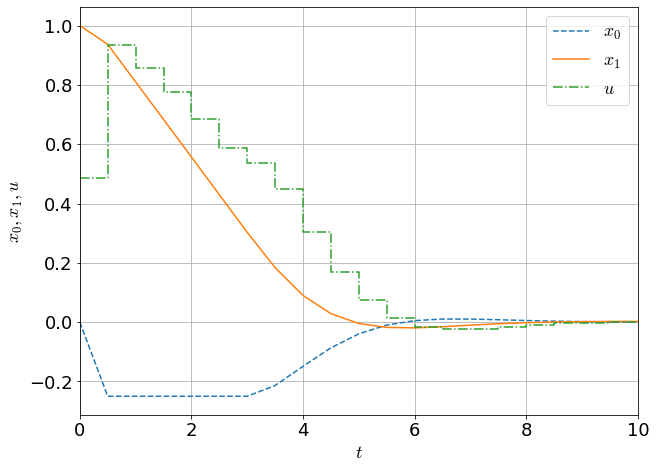

In [3]:
########## Parameters ##########
T = 10
N = 20
################################

########## Instance ##########
direct_single_shooting = Direct_single_shooting(T=T, N=N)
##############################

########## figure ##########
x0 = MX.sym('x0')
x1 = MX.sym('x1')
u = MX.sym('u')
xinit = [0, 1]
direct_single_shooting.plot_solution(x0=x0, x1=x1, u=u, xinit=xinit)
############################